### Aprendizagem de Máquina - Lista 01

#### Aluno: João Victor Alves de Oliveira - 473977

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [49]:
def MSE(x, y, w):
    y2 = x @ w
    return ((y - y2) ** 2).mean()

def RMSE(x, y, w):
    return MSE(x, y, w) ** 0.5

def normalize(x):
    return x / np.linalg.norm(x)


def GD(x, y, w, alpha, epochs):
    custos = np.zeros(epochs)

    for epoch in range(epochs):
        y2 = x @ w
        w = w + alpha * (x.T @ (y - y2))
        custos[epoch] = MSE(x, y, w)

    return w, custos


def SGD(x, y, w, alpha, epochs):
    n, m = x.shape
    custos = np.zeros((epochs * n))

    for epoch in range(epochs):
        for i in range(n):
            y2 = x[i] @ w
            error = (y[i] - y2)
            w = w + alpha * error * x[i].reshape((1, -1)).T
            custos[epoch * n + i] = MSE(x, y, w)

    return w, custos


def OLS(x, y, L2=1000):
    return np.linalg.solve(x.T @ x + L2 * np.eye(x.shape[1]), x.T @ y)
    # return np.linalg.inv(x.T @ x + L2 * np.eye(x.shape[1])) @ x.T @ y
    # return np.linalg.solve(x.T @ x, x.T @ y)


# Questão 01

## Lendo o dataset, criando as variáveis x e y

In [213]:
dataset = np.genfromtxt('./artificial1d.csv', delimiter=',', skip_header=0)
print(dataset.shape)
n, m = dataset.shape

x = np.c_[np.ones((n, 1)), dataset[:, :m-1]]
y = dataset[:, -1].reshape((-1, 1))

print(x.shape, y.shape)
nx = normalize(x)

(30, 2)
(30, 2) (30, 1)


## a) Treinando o modelo com OLS

parâmetros:
[[ 0.43132422]
 [10.04581978]]
MSE: 25.914295019215235


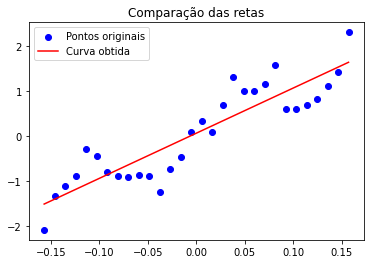

In [214]:
w = OLS(nx, y, L2=0)
print('parâmetros:')
print(w)
print('MSE:', MSE(x, y, w))

plt.title('Comparação das retas')
plt.scatter(nx[:, 1], y, c='b', label='Pontos originais')
plt.plot(nx[:, 1], nx @ w, c='r', label='Curva obtida')
plt.legend()
plt.show()

## b) Treinando o modelo com GD

(2, 1)
parâmetros:
[[ 0.43132422]
 [10.0134513 ]]
MSE 25.71926722966442


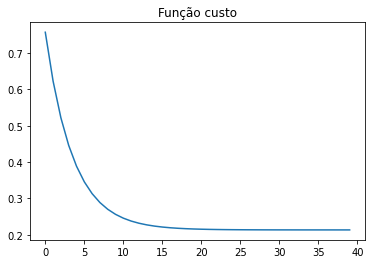

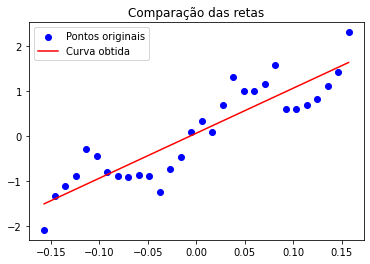

In [216]:
w = np.ones((m, 1))
print(w.shape)

alpha = 0.5
epochs = 40

w, custos = GD(nx, y, w, alpha, epochs)

print('parâmetros:')
print(w)
print('MSE', MSE(x, y, w))

plt.title('Função custo')
plt.plot(custos)
plt.show()

plt.title('Comparação das retas')
plt.scatter(nx[:, 1], y, c='b', label='Pontos originais')
plt.plot(nx[:, 1], nx @ w, c='r', label='Curva obtida')
plt.legend()
plt.show()

## c) Treinando o modelo com SGD

(2, 1)
parâmetros:
[[0.45270157]
 [9.72039386]]
MSE 24.003515217019867


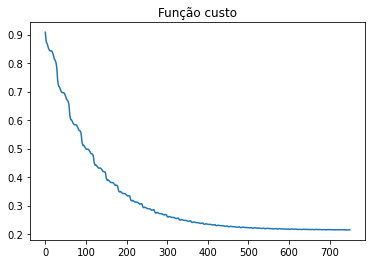

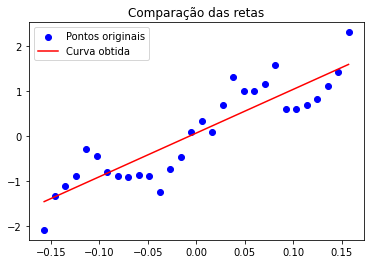

In [223]:
w = np.ones((m, 1))
print(w.shape)

alpha = 0.5
epochs = 25

w, custos = SGD(nx, y, w, alpha, epochs)

print('parâmetros:')
print(w)
print('MSE', MSE(x, y, w))

plt.title('Função custo')
plt.plot(custos)
plt.show()

plt.title('Comparação das retas')
plt.scatter(nx[:, 1], y, c='b', label='Pontos originais')
plt.plot(nx[:, 1], nx @ w, c='r', label='Curva obtida')
plt.legend()
plt.show()

# Questão 02

In [69]:
dataset = np.genfromtxt('./california.csv', delimiter=',', skip_header=0)
print(dataset.shape)
n, m = dataset.shape

(5000, 9)


In [176]:
def shuffle():
    global dataset

    train_size, test_size = 0.8, 0.2
    n, m = dataset.shape
    np.random.shuffle(dataset)
    train_set, test_set = dataset[:int(train_size * n), :], dataset[int(train_size * n):, :]

    x1 = np.c_[np.ones((int(train_size * n), 1)), train_set[:, :m-1]]
    y1 = train_set[:, -1].reshape((-1, 1))
    x2 = np.c_[np.ones((int(test_size * n), 1)), test_set[:, :m-1]]
    y2 = test_set[:, -1].reshape((-1, 1))

    return x1, x2, y1, y2


In [101]:
def poly_features(X, degree=2):
    features = np.hstack([X**(i+1) for i in range(degree)])
    features = np.c_[np.ones(len(features)), features]

    return features

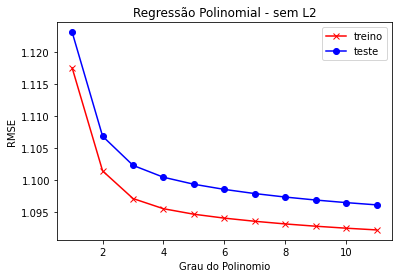

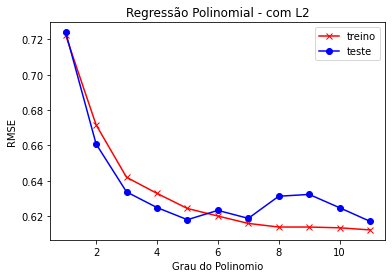

In [212]:
def train_models(useL2=False):
    x1, x2, y1, y2 = shuffle()

    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x1 = scaler_x.fit_transform(x1)
    x2 = scaler_x.transform(x2)
    y1 = scaler_y.fit_transform(y1)

    hist_rmse = ([], [])
    for i in range(1, 12):
        x_train = poly_features(x1, i)
        x_test = poly_features(x2, i)

        if useL2:
            w = OLS(x_train, y1, L2=1e-10)
        else:
            w = OLS(x_train, y1)

        prediction_train = x_train @ w
        prediction_test = x_test @ w

        prediction_train = scaler_y.inverse_transform(prediction_train)
        prediction_test = scaler_y.inverse_transform(prediction_test)

        rmse_train = np.sqrt(np.mean((scaler_y.inverse_transform(y1) - prediction_train)**2))
        rmse_test = np.sqrt(np.mean((y2 - prediction_test)**2))

        hist_rmse[0].append(rmse_train)
        hist_rmse[1].append(rmse_test)

    grau = np.linspace(1, 11, 11)
    plt.title(f"Regressão Polinomial - {'com' if useL2 else 'sem'} L2")
    plt.plot(grau, hist_rmse[0], 'rx-', label="treino")
    plt.plot(grau, hist_rmse[1], 'bo-', label="teste")
    plt.legend()
    plt.xlabel("Grau do Polinomio")
    plt.ylabel("RMSE")
    plt.show()

train_models()
train_models(useL2=True)